In [1]:
s=!nvcc --version
print('\n'.join(s).split(' ')[-1][1:5])
import torch
print(torch.__version__)

uda_
1.8.1+cu101


In [2]:
# !python -m pip install gdown detectron2 -f \
#   https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.7/index.html

In [3]:
import os
if os.path.exists("datasets.zip") is False:
  !gdown https://drive.google.com/uc?id=17bOUzX9cmYJlNCa2rL4ziSCZVY_8oD3e

Downloading...
From: https://drive.google.com/uc?id=17bOUzX9cmYJlNCa2rL4ziSCZVY_8oD3e
To: /content/datasets.zip
909MB [00:12, 74.9MB/s]


In [4]:
if os.path.exists('Aditional Dataset') is False:
  !unzip -q datasets.zip

In [5]:
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

     |████████████████████████████████| 276kB 7.2MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44074 sha256=489582f03995d427bb5d9bbacd9b19004e4ea2fea9b17bab8d3caeaac5b64657
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
1.8.1+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [6]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.8)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.8")   # need to manually install torch 1.8 if Colab changes its default version
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
# # exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
     |████████████████████████████████| 6.2MB 1.2MB/s 
     |████████████████████████████████| 51kB 6.2MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.3.post20210317-cp37-none-any.whl size=58543 sha256=67f5316e92b3d02373e9725c6409d8d1ae0598804a2477c95a91315438b62dc8
  Stored in directory: /root/.cache/pip/wheels/d2/ee/3a/5c531df777c03d8c67f22c65f97d6f75321087482d05a9b218
Successfully built fvcore


In [7]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
# from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [8]:
from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog,build_detection_train_loader
import os
import json
data = [
    'Aditional Dataset/vott-json-export (Недоливы)',
    'Aditional Dataset/vott-json-export (Трещины)',
    'Training Dataset/vott-json-export (Раковины)'
         ]

#%%

if os.path.exists('train') is False:
    os.mkdir('train')
if os.path.exists('test') is False:
    os.mkdir('test')

#%%
labels_encoder={'Недоливы':0,'Трещины':1}
labels_encoder={'Недоливы':0,'Трещины':1,'Раковины':2}
# labels_encoder={'Недоливы':0,}
# labels_encoder={'Трещины':0}
#%%

def get_meta(dirs):
    all =[]
    for dir in dirs:
        json_file = [i for i in os.listdir(dir) if i.endswith('json')]
        assert len(json_file)==1
        json_file=json_file[0]
        with open(dir+'/'+json_file) as f:
            dict = json.load(f)
            for asset in dict['assets'].values():
                record={}
                
                record['file_name']=os.path.abspath(dir+'/'+asset['asset']['name'])
                record["image_id"] = asset['asset']['id']
                # height, width = cv2.imread(record['file_name']).shape[:2]

                # record["height"]=height
                # record["width"] = width
                record["height"] = asset['asset']['size']['height']
                record["width"] = asset['asset']['size']['width']
                objs=[]
                for region in asset['regions']:
                    obj = {
                        'bbox':[region['boundingBox']['left'],region['boundingBox']['top'],
                                region['boundingBox']['width'],region['boundingBox']['height']],
                        'bbox_mode' : BoxMode.XYWH_ABS,
                        'category_id':labels_encoder[region['tags'][0]]
                    }
                    objs.append(obj)
                record['annotations']=objs
                all.append(record)
    return all
all=get_meta(data)

In [9]:
bad = [3784,3789,3790,3791,3797,3798,3806,3807,3811,3815,3817,3820,3821,
3822,3823,3824,3833,3842,3843,3847,3849,
      3727,3681,3742,3743,3778,3868]

bad2 =[3783,3785,3787,3808,3809,3814,3827,3831,3840,3846,3848,
      
      3692,3694,3695,3696,3701,3704,3707,3709,3721,3722,3764,3766,3739]
len(bad+bad2)
bad=bad+bad2

In [10]:
all2=all
all=[]
for i in all2:
    flag=True
    for j in bad:
        if i['file_name'].split('/')[-1].find(str(j))!=-1:
            flag=False
            break
    if flag:
        all.append(i)

In [11]:
len(all2)

179

In [12]:
buf=np.random.permutation(np.array(all))
choice1 = np.random.choice(buf.shape[0],int(np.round(buf.shape[0]*0.2)),replace=False)
choice2 = np.setdiff1d(np.arange(buf.shape[0]),choice1)
train=list(buf[choice2])
test=list(buf[choice1])
# train=all[:5]
# test=all[10:12]

In [13]:
if 'kek_train' not in DatasetCatalog.keys():
  DatasetCatalog.register("kek_train", lambda :train)
  MetadataCatalog.get("kek_train" ).set(thing_classes=list(labels_encoder.keys()))

  DatasetCatalog.register("kek_test", lambda :test)
  MetadataCatalog.get("kek_test" ).set(thing_classes=list(labels_encoder.keys()))

  kek_metadata = MetadataCatalog.get("kek_train")

In [14]:
kek_metadata

Metadata(name='kek_train', thing_classes=['Недоливы', 'Трещины', 'Раковины'])

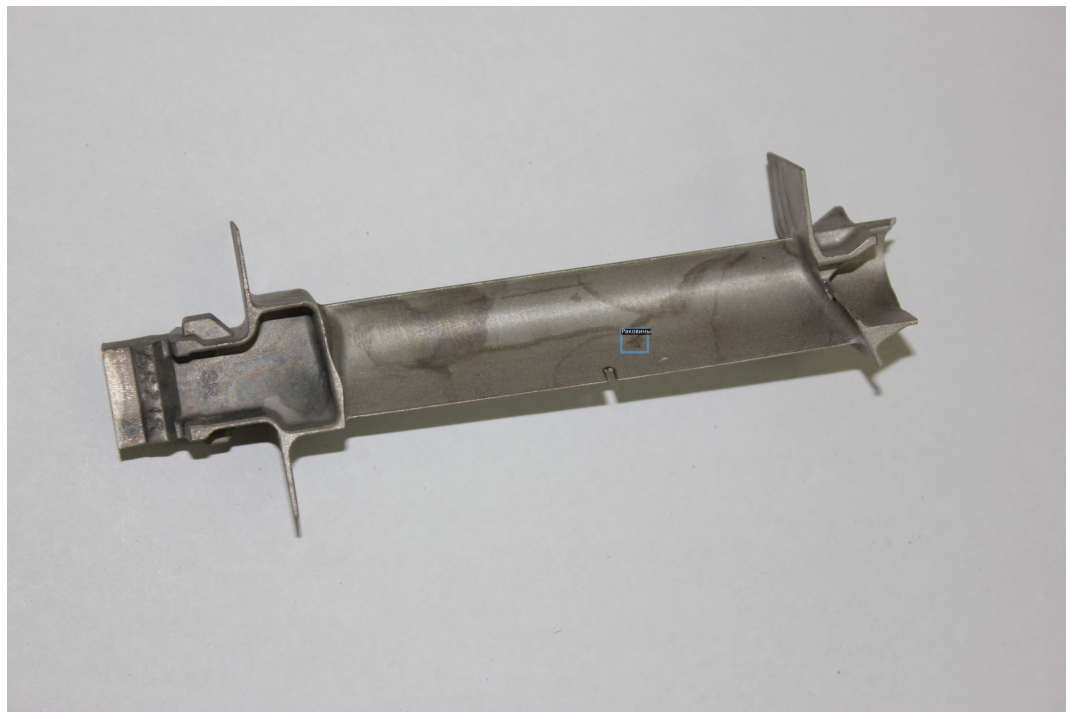

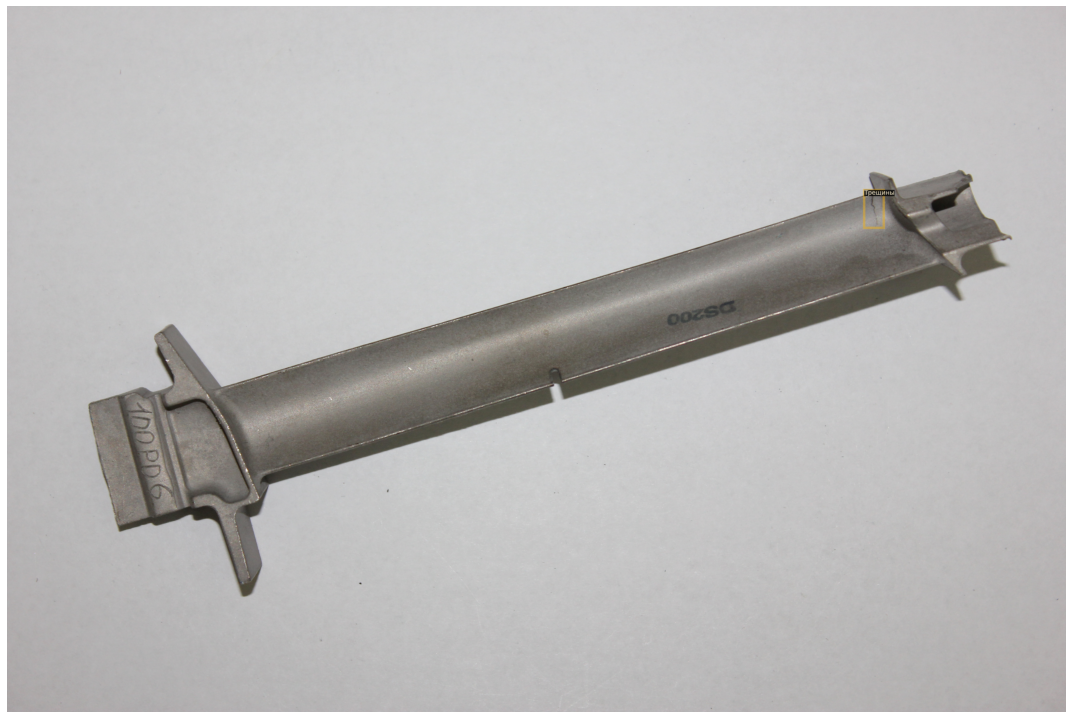

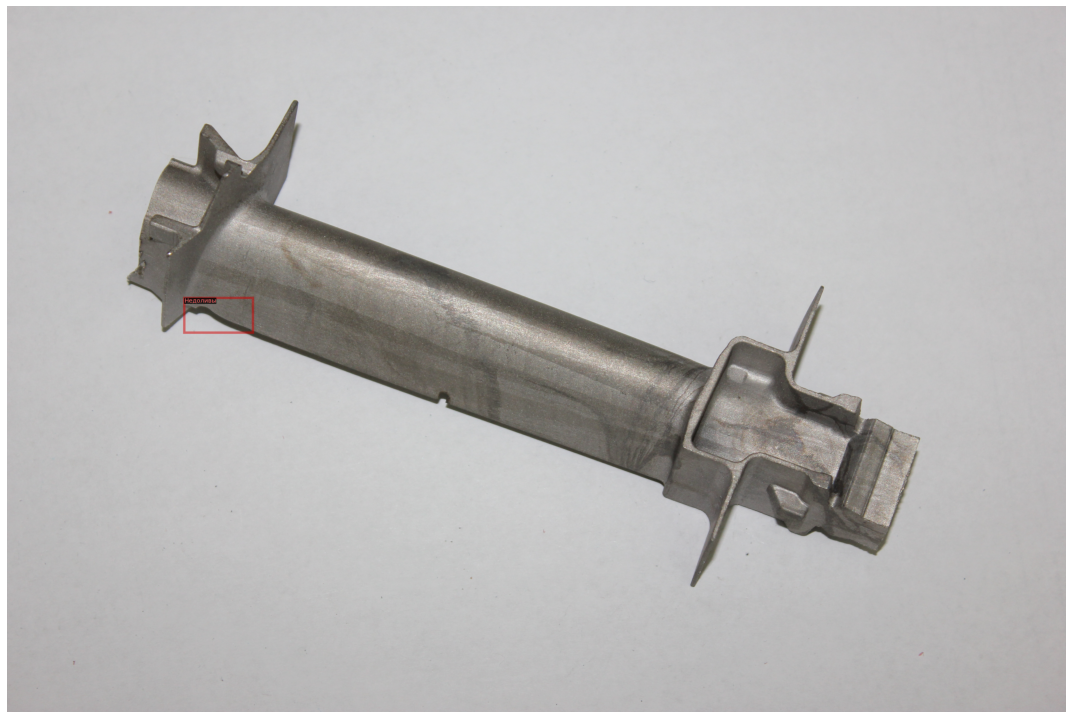

In [15]:
import matplotlib.pyplot as plt
def cv2_imshow(a):
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.imshow(cv2.cvtColor(a, cv2.COLOR_BGR2RGB))
    ax.axis('off')
    plt.tight_layout()
#Visualizing the Train Dataset
# dataset_dicts = get_board_dicts("Text_Detection_Dataset_COCO_Format/train")
dataset_dicts=train
#Randomly choosing 3 images from the Set
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=kek_metadata,scale=1)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [16]:
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [17]:
from detectron2.data import detection_utils as utils
import detectron2.data.transforms as T
import copy
def custom_mapper(dataset_dict):
    # Implement a mapper, similar to the default DatasetMapper, but with your own customizations
    dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
    image = utils.read_image(dataset_dict["file_name"], format="BGR")
    transform_list = [
                      T.Resize((int(5184//2.5),int(3456//2.5))),
#                       T.RandomFlip(prob=0.2, horizontal=False, vertical=True),
#                       T.RandomFlip(prob=0.2, horizontal=True, vertical=False), 
                      # T.RandomCrop("absolute", (5184//4, 3456//4))
                      ]
    image, transforms = T.apply_transform_gens(transform_list, image)
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
        if obj.get("iscrowd", 0) == 0
    ]
    instances = utils.annotations_to_instances(annos, image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    return dataset_dict


class WheatTrainer(DefaultTrainer):
    
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=custom_mapper)

In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()

cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_101_FPN_3x.yaml"))
# cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("kek_train",)
cfg.DATASETS.TEST = ("kek_test",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_101_FPN_3x.yaml")  # Let training initialize from model zoo
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 1
cfg.SOLVER.BASE_LR = 0.0000225  # pick a good LR
cfg.SOLVER.BASE_LR = 0.0000025  
cfg.SOLVER.MAX_ITER = 500    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []      
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE =512  


cfg.TEST.EVAL_PERIOD = 50



cfg.MODEL.RETINANET.NUM_CLASSES=3
cfg.TEST.DETECTIONS_PER_IMAGE=3



os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
# trainer = CocoTrainer(cfg,)
trainer = WheatTrainer(cfg,) 
# trainer = CustomTrainer(cfg)
# trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

Loading config /usr/local/lib/python3.7/dist-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


[04/25 12:56:08 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

model_final_971ab9.pkl: 228MB [00:03, 67.4MB/s]                           
Skip loading parameter 'head.cls_score.weight' to the model due to incompatible shapes: (720, 256, 3, 3) in the checkpoint but (27, 256, 3, 3) in the model! You might want to double check if this is expected.
Skip loading parameter 'head.cls_score.bias' to the model due to incompatible shapes: (720,) in the checkpoint but (27,) in the model! You might want to double check if this is expected.


[04/25 12:56:13 d2.engine.train_loop]: Starting training from iteration 0


In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  
#cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

In [ ]:
from shutil import copyfile
copyfile(os.path.join(cfg.OUTPUT_DIR, "model_final.pth"), './model_final.pth')

In [ ]:
im = cv2.imread(train[2]["file_name"])
outputs = predictor(im)
outputs

In [ ]:
# from detectron2.utils.visualizer import ColorMode
dataset_dicts = test
for d in random.sample(dataset_dicts, 4):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=kek_metadata, 
                   scale=0.5, 
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader


evaluator = COCOEvaluator("kek_test", cfg, False, output_dir="/output/")
val_loader = build_detection_test_loader(cfg, "kek_test")

inference_on_dataset(predictor.model, val_loader, evaluator)


In [ ]:
1/0